In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# !pip install category_encoders

In [ ]:
from category_encoders import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install xgboost

In [ ]:
import xgboost as xgb
xgb.__version__

'0.90'

In [ ]:
# Model and performance evaluation
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
lbl = preprocessing.LabelEncoder()
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score
# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

In [ ]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Crossroads/engg_data/crossroads_full_feature_set.csv")

In [ ]:
explicit_no_acc = df[df['isAttended']=="???"]['acct_id'].values

In [ ]:
df.isnull().sum()

acct_id                           0
acct_type_desc                91418
event_name                        0
event_date                        0
plan_event_name              279172
comp_name                     80644
section_name                      0
row_name                          0
SeatNum                           0
price_code                        0
PC1                               0
Price                             0
paid                         154145
add_datetime                  80644
class_name                        0
status                            0
Sales_Source                1280704
isHost                            0
SeatType                          0
TicketClass                       0
Start Year                  1146325
LastYear                    1146325
Term                        1146445
TicketType                        0
SeatUniqueID                      0
Season                            0
ClubExpYear                 1146325
Tenure                      

In [ ]:
# df[["acct_type_desc"]] = df[["acct_type_desc"]].fillna("NA")
# df[["acct_type_group"]] = df[["acct_type_group"]].fillna("NA")
# df[["plan_event_name"]] = df[["plan_event_name"]].fillna("NA")
# df[["plan_event_name_group"]] = df[["plan_event_name_group"]].fillna("NA")
# df[["Sales_Source"]] = df[["Sales_Source"]].fillna("NA")
# df[["Zone"]] = df[["Zone"]].fillna("NA")
# df[["comp_name"]] = df[["comp_name"]].fillna("NA")
# df[["comp_names_group"]] = df[["comp_names_group"]].fillna("NA")
# df[["class_name_grp"]] = df[["class_name_grp"]].fillna("NA")

In [ ]:
def pivot(train_data, group_cols, agg_col):
    data = train_data.groupby(group_cols).agg({agg_col: "count"}).reset_index()
    data = pd.pivot_table(data, values=agg_col, index=[group_cols[0]], columns=[group_cols[1]], aggfunc=np.sum).reset_index().rename_axis(None, axis=1)
    data = data.fillna(0)
    data["count"] = data["Yes"] + data["No"]
    data["%Attended"] = 100*data["Yes"]/(data["Yes"]+data["No"])
    return data

In [ ]:
accnt_type_df = pivot(df, ["acct_id", "isAttended"], "UniqueID")
accnt_type_df.head()

,acct_id,???,No,Yes,count,%Attended
0,190,6467.0,68700.0,369.0,69069.0,0.534248
1,14999990,0.0,8.0,0.0,8.0,0.000000
2,16999990,0.0,1.0,0.0,1.0,0.000000
3,110002390,14.0,29.0,97.0,126.0,76.984127
4,110003490,20.0,25.0,135.0,160.0,84.375000


In [ ]:
"count", "%Attended", "event_name_count"

('count', '%Attended', 'event_name_count')

In [ ]:
temp = df[df["isAttended"]!="???"]
acct_count_df = temp.groupby("acct_id").agg({"event_name": "nunique"}).reset_index()
acct_count_df = acct_count_df.rename(columns={"event_name": "event_name_count"})
acct_count_df.head()

,acct_id,event_name_count
0,190,18
1,14999990,2
2,16999990,1
3,110002390,18
4,110003490,16


In [ ]:
df = df.merge(accnt_type_df[["acct_id", "count", "%Attended"]], on="acct_id", how="left")
df = df.merge(acct_count_df[["acct_id", "event_name_count"]], on="acct_id", how="left")

In [ ]:
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,paid,add_datetime,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Start Year,LastYear,Term,TicketType,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,isAttended,Resold,ResalePrice,ResaleDate,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Game Time,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,F,111.0,Y,2021-03-31 16:08:52,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,Yes,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,F,111.0,Y,2021-03-31 16:10:20,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,Yes,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,F,111.0,Y,2021-03-31 16:08:21,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,No,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0


In [ ]:
df.isnull().sum()["%Attended"]

13443

In [ ]:
t0 = df[(df["isAttended"]=="???") & (df["%Attended"]<21) & (df["count"]>=10) & (df["event_name_count"]>2)]
t0.shape, t0.acct_id.nunique()

((7128, 69), 96)

In [ ]:
t = df[df["isAttended"]=="???"]
t.shape, t.acct_id.nunique()

((128688, 69), 22102)

In [ ]:
100.0*7128/128688

5.538977993286087

In [ ]:
att  = df["isAttended"].values
df = df.drop("isAttended", 1)
df["isAttended"] = att

In [ ]:
df.head()

,acct_id,acct_type_desc,event_name,event_date,plan_event_name,comp_name,section_name,row_name,SeatNum,price_code,PC1,Price,paid,add_datetime,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Start Year,LastYear,Term,TicketType,SeatUniqueID,Season,ClubExpYear,Tenure,UniqueID,Resold,ResalePrice,ResaleDate,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Game Time,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count,isAttended
0,117948790,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,1,FR,F,111.0,Y,2021-03-31 16:08:52,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-1,2021,NaN,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0,Yes
1,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,10,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-10,2021,NaN,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,No
2,126665090,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,11,FR,F,111.0,Y,2021-03-31 16:08:19,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-11,2021,NaN,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,No
3,1489599590,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,12,FR,F,111.0,Y,2021-03-31 16:10:20,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-12,2021,NaN,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0,Yes
4,115101990,Season,CLT21HOU,2021-10-17,21FS,Not Comp,101,10,13,FR,F,111.0,Y,2021-03-31 16:08:21,OPEN,SOLD,NaN,0,GA,Manifest,NaN,NaN,NaN,Renewal,101-10-13,2021,NaN,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,13:00,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0,No


In [ ]:
# df[["event_name", "event_date"]].drop_duplicates().sort_values("event_date").reset_index(drop=True)

In [ ]:
df = df.drop(["acct_id", "event_date", "section_name", "row_name", "SeatNum", "Game Time", 
              "add_datetime", "Start Year", "LastYear", "SeatUniqueID", "ResaleDate", 
              "ClubExpYear"], 1)


In [ ]:
df["Season"] = df["Season"].astype(str)

In [ ]:
cat_cols = []
for k,v in dict(df.dtypes).items():
  if v=="object":
    cat_cols.append(k)

cat_cols = list(set(cat_cols) - set(["event_name", "UniqueID", "isAttended"]))

In [ ]:
# cat_cols

In [ ]:
from pandas.core.indexes import category
for col in cat_cols:
  df[col] = df[col].astype("category")

In [ ]:
def label_encode(row, col):
  if row[col]=="Yes":
    return 1
  elif row[col]=="No":
    return 0
  else:
    return row[col]

df["isAttended"] = df.apply(lambda x: label_encode(x, "isAttended"), 1)

In [ ]:
df.shape

(1286916, 57)

In [ ]:
df.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,count,%Attended,event_name_count,isAttended
0,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,54.0,94.444444,18.0,1
1,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,0
2,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,72.0,70.833333,18.0,0
3,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,18.0,83.333333,18.0,1
4,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,144.0,72.222222,18.0,0


In [ ]:
train_df = df[(df["isAttended"]!="???") & (~df["event_name"].isin(["CLT22LAC"]))]
# train_df = df[df["isAttended"]!="???"]
val_df = df[(df["isAttended"]!="???") & (df["event_name"].isin(["CLT22LAC"]))]
test_df = df[df["isAttended"]=="???"]

In [ ]:
train_cnt = train_df["count"].values
train_att = train_df["%Attended"].values
train_event_cnt = train_df["event_name_count"].values

val_cnt = val_df["count"].values
val_att = val_df["%Attended"].values
val_event_cnt = val_df["event_name_count"].values

test_cnt = test_df["count"].values
test_att = test_df["%Attended"].values
test_event_cnt = test_df["event_name_count"].values

In [ ]:
train_df = train_df.drop(["count", "%Attended", "event_name_count"], 1)
val_df = val_df.drop(["count", "%Attended", "event_name_count"], 1)
test_df = test_df.drop(["count", "%Attended", "event_name_count"], 1)

In [ ]:
train_df.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag,isAttended
0,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,1
1,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,0
2,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,0
3,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,1
4,Season,CLT21HOU,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1,0


In [ ]:
# train_df, encoder = label_encode_columns(train_df, cat_cols)
# val_df, _ = label_encode_columns(val_df, cat_cols)
# test_df, _ = label_encode_columns(test_df, cat_cols)

In [ ]:
test_df["isAttended"].unique()

array(['???'], dtype=object)

In [ ]:
train_df.shape, val_df.shape, test_df.shape

((1093882, 54), (64346, 54), (128688, 54))

In [ ]:
train_df["event_name"].nunique(), val_df["event_name"].nunique(), test_df["event_name"].nunique()

(17, 1, 2)

In [ ]:
X_train = train_df.iloc[:, :-1]
y_train = train_df.iloc[:, -1].values
X_val = val_df.iloc[:, :-1]
y_val = val_df.iloc[:, -1].values
X_test = test_df.iloc[:, :-1]
y_test = test_df.iloc[:, -1].values

In [ ]:
enc = TargetEncoder(cols=cat_cols, min_samples_leaf=20, smoothing=10, handle_missing = 'return_nan').fit(X_train, y_train)
X_train_encoded = enc.transform(X_train)
X_val_encoded = enc.transform(X_val)
X_test_encoded = enc.transform(X_test)

In [ ]:
X_train_encoded.head()

,acct_type_desc,event_name,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,UniqueID,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag
0,0.846107,CLT21HOU,0.831166,0.84053,0.854265,0.844127,111.0,0.830127,0.826925,0.84053,NaN,0,0.769737,0.796803,NaN,0.847942,0.752743,25.0,CLT21HOU-101-10-1,NaN,NaN,NaN,0.844646,0.832654,0.79884,0.781132,0.813165,0.752246,0.838715,0.84072,0.832049,0.832126,0.794238,0.841972,199.4,NaN,NaN,1.0,0.671998,0.684329,0.677114,0.679989,0.816608,6,0.782914,108,89,2.5,184.4,52.12,0.0,39.62,1
1,0.846107,CLT21HOU,0.831166,0.84053,0.854265,0.844127,111.0,0.830127,0.826925,0.84053,NaN,0,0.769737,0.796803,NaN,0.847942,0.752743,20.0,CLT21HOU-101-10-10,NaN,NaN,NaN,0.844646,0.832654,0.79884,0.781132,0.813165,0.752246,0.838715,0.84072,0.832049,0.832126,0.794238,0.841972,199.4,NaN,NaN,1.0,0.671998,0.684329,0.677114,0.679989,0.816608,6,0.782914,108,89,2.5,184.4,52.12,0.0,39.62,1
2,0.846107,CLT21HOU,0.831166,0.84053,0.854265,0.844127,111.0,0.830127,0.826925,0.84053,NaN,0,0.769737,0.796803,NaN,0.847942,0.752743,20.0,CLT21HOU-101-10-11,NaN,NaN,NaN,0.844646,0.832654,0.79884,0.781132,0.813165,0.752246,0.838715,0.84072,0.832049,0.832126,0.794238,0.841972,199.4,NaN,NaN,1.0,0.671998,0.684329,0.677114,0.679989,0.816608,6,0.782914,108,89,2.5,184.4,52.12,0.0,39.62,1
3,0.846107,CLT21HOU,0.831166,0.84053,0.854265,0.844127,111.0,0.830127,0.826925,0.84053,NaN,0,0.769737,0.796803,NaN,0.847942,0.752743,4.0,CLT21HOU-101-10-12,NaN,NaN,NaN,0.844646,0.832654,0.79884,0.781132,0.813165,0.752246,0.838715,0.84072,0.832049,0.832126,0.794238,0.841972,199.4,NaN,NaN,1.0,0.671998,0.684329,0.677114,0.679989,0.816608,6,0.782914,108,89,2.5,184.4,52.12,0.0,39.62,1
4,0.846107,CLT21HOU,0.831166,0.84053,0.854265,0.844127,111.0,0.830127,0.826925,0.84053,NaN,0,0.769737,0.796803,NaN,0.847942,0.752743,32.0,CLT21HOU-101-10-13,NaN,NaN,NaN,0.844646,0.832654,0.79884,0.781132,0.813165,0.752246,0.838715,0.84072,0.832049,0.832126,0.794238,0.841972,199.4,NaN,NaN,1.0,0.671998,0.684329,0.677114,0.679989,0.816608,6,0.782914,108,89,2.5,184.4,52.12,0.0,39.62,1


In [ ]:
train_ids = X_train["UniqueID"].values
val_ids = X_val["UniqueID"].values
test_ids = X_test["UniqueID"].values

X_train = X_train.drop(["UniqueID", "event_name"], 1)
X_val = X_val.drop(["UniqueID", "event_name"], 1)
X_test = X_test.drop(["UniqueID", "event_name"], 1)

In [ ]:
train_ids = X_train_encoded["UniqueID"].values
val_ids = X_val_encoded["UniqueID"].values
test_ids = X_test_encoded["UniqueID"].values

X_train_encoded = X_train_encoded.drop(["UniqueID", "event_name"], 1)
X_val_encoded = X_val_encoded.drop(["UniqueID", "event_name"], 1)
X_test_encoded = X_test_encoded.drop(["UniqueID", "event_name"], 1)

In [ ]:
X_train.head()

,acct_type_desc,plan_event_name,comp_name,price_code,PC1,Price,paid,class_name,status,Sales_Source,isHost,SeatType,TicketClass,Term,TicketType,Season,Tenure,Resold,ResalePrice,isSTM,acct_type_group,plan_event_name_group,row_name_group,seat_nums_group,section_names_group,Zone,comp_names_group,price_group,PC1_group,class_name_grp,ticket_class_grp,TicketType_group,no_days_prebooked,gameday_minus_start_year,lastyear_minus_gameday,section_group,section_group_segment,section_name_segment,row_segment,seat_segment,Game_Type,Week,week_day,Home Points,Away Points,unemployment_rate,covid_cases,Avg_Day_Temp,Precipitation,Avg_Dew_Point,weekend_flag
0,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,25.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1
1,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1
2,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,20.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1
3,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,4.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1
4,Season,21FS,Not Comp,FR,F,111.0,Y,OPEN,SOLD,NaN,0,GA,Manifest,NaN,Renewal,2021,32.0,NaN,NaN,NaN,G1,G1,G1,G1,G1,N,G1,price_group_3,PC1_group_2,class_name_2,ticket_class_1,group_0,199.4,NaN,NaN,1.0,Low,Low,Low,Low,Reg,6,Sunday,108,89,2.5,184.4,52.12,0.0,39.62,1


In [ ]:
# Define the search space
param_grid = { 
    "max_depth": [4,5,6,7],
    "n_estimators": [200,500,1000,1500],
    # "min_child_weight": [2,3,4],
    # # Percentage of columns to be randomly samples for each tree.
    # "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    # "reg_alpha": [0, 0.5, 1, 5],
    # # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    # "reg_lambda": [0, 0.5, 1, 5],
    # "scale_pos_weight": [1, 0.286, 3.502]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [ ]:
df["isAttended"].value_counts()

1      900945
0      257283
???    128688
Name: isAttended, dtype: int64

In [ ]:
257283/900945, 900945/257283

(0.28557015134109187, 3.5017665372372058)

In [ ]:
# Initiate XGBoost Classifier
xgboost = XGBClassifier(objective='binary:logistic', max_depth=6, n_estimators=200, min_child_weight=3, reg_alpha=0,
                        reg_lambda=0.8, eval_metric="auc",
                        tree_method="gpu_hist", enable_categorical=True)
# Print default setting
xgboost.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 200,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0.8,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1,
 'eval_metric': 'auc',
 'tree_method': 'gpu_hist',
 'enable_categorical': True}

In [ ]:
# Define grid search
grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=-1, 
                           cv=kfold, 
                           verbose=0)
# Fit grid search
grid_result = grid_search.fit(X_train_encoded, [int(each) for each in y_train.tolist()])

# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

KeyboardInterrupt: ignored

In [ ]:
# y_pred_val = grid_search.predict(X_val)

In [ ]:
y_pred_val = [each[1] for each in grid_search.predict_proba(X_val)]
y_pred_val = [1 if each>0.5 else 0 for each in y_pred_val]

print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))

In [ ]:
y_pred_val = [each[1] for each in grid_search.predict_proba(X_val)]
y_pred_val = [1 if each>0.55 else 0 for each in y_pred_val]

print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))

In [ ]:
xgboost.fit(X_train_encoded, [int(each) for each in y_train.tolist()], 
            eval_set=[(X_train_encoded, y_train), (X_val_encoded, y_val)], 
            verbose=2, early_stopping_rounds=30)

[0]	validation_0-auc:0.791998	validation_1-auc:0.639973
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[2]	validation_0-auc:0.79667	validation_1-auc:0.659079
[4]	validation_0-auc:0.799265	validation_1-auc:0.658638
[6]	validation_0-auc:0.799655	validation_1-auc:0.658697
[8]	validation_0-auc:0.800426	validation_1-auc:0.691685
[10]	validation_0-auc:0.801656	validation_1-auc:0.702276
[12]	validation_0-auc:0.802237	validation_1-auc:0.699574
[14]	validation_0-auc:0.802843	validation_1-auc:0.704586
[16]	validation_0-auc:0.803792	validation_1-auc:0.703598
[18]	validation_0-auc:0.804471	validation_1-auc:0.703523
[20]	validation_0-auc:0.804968	validation_1-auc:0.703494
[22]	validation_0-auc:0.805426	validation_1-auc:0.704231
[24]	validation_0-auc:0.805841	validation_1-auc:0.704375
[26]	validation_0-auc:0.806263	validation_1-auc:0.704238
[28]	validation_0-auc:0.806771	validation_1-auc:0.7

XGBClassifier(enable_categorical=True, eval_metric='auc', max_depth=6,
              min_child_weight=3, n_estimators=200, reg_lambda=0.8,
              tree_method='gpu_hist')

In [ ]:
imp_df = pd.DataFrame({"Feature": X_train_encoded.columns, "Importance": xgboost.feature_importances_})
sum_ = imp_df["Importance"].sum()
imp_df["Importance%"] = round(100.0*imp_df["Importance"]/sum_, 2)
imp_df = imp_df.sort_values("Importance%", ascending=False).reset_index(drop=True)
imp_df

,Feature,Importance,Importance%
0,comp_name,0.468552,46.860001
1,Game_Type,0.314631,31.459999
2,Resold,0.029788,2.980000
3,Home Points,0.023143,2.310000
4,TicketType,0.021816,2.180000
5,acct_type_group,0.019331,1.930000
6,acct_type_desc,0.012462,1.250000
7,seat_segment,0.012123,1.210000
8,plan_event_name,0.008171,0.820000
9,Week,0.008028,0.800000


In [ ]:
imp_df.iloc[:45]["Feature"].values

array(['comp_name', 'Game_Type', 'Resold', 'Home Points', 'TicketType',
       'acct_type_group', 'acct_type_desc', 'seat_segment',
       'plan_event_name', 'Week', 'section_group_segment', 'paid',
       'Away Points', 'price_code', 'covid_cases', 'Avg_Day_Temp',
       'Tenure', 'row_segment', 'unemployment_rate', 'comp_names_group',
       'isHost', 'section_group', 'ResalePrice', 'section_names_group',
       'no_days_prebooked', 'isSTM', 'class_name_grp', 'TicketType_group',
       'PC1', 'gameday_minus_start_year', 'Price', 'Season', 'class_name',
       'section_name_segment', 'TicketClass', 'Zone', 'price_group',
       'week_day', 'Term', 'Sales_Source', 'Avg_Dew_Point',
       'weekend_flag', 'row_name_group', 'PC1_group',
       'lastyear_minus_gameday'], dtype=object)

In [ ]:
y_pred_val = xgboost.predict(X_val_encoded)

In [ ]:
print(classification_report([int(each) for each in y_val.tolist()], y_pred_val))


              precision    recall  f1-score   support

           0       1.00      0.20      0.34     11106
           1       0.86      1.00      0.92     53240

    accuracy                           0.86     64346
   macro avg       0.93      0.60      0.63     64346
weighted avg       0.88      0.86      0.82     64346



In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix=confusion_matrix([int(each) for each in y_val.tolist()], y_pred_val)
cf_matrix

array([[ 2270,  8836],
       [    1, 53239]])

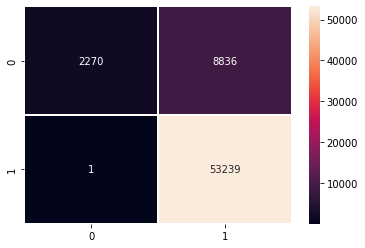

In [ ]:
import seaborn as sns 
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')

In [ ]:
val_pred_df = pd.DataFrame()
val_pred_df["UniqueID"] = val_ids
val_pred_df["count"] = val_cnt
val_pred_df["%Attended"] = val_att
val_pred_df["event_name_count"] = val_event_cnt
val_pred_df["class_name"] = val_df["class_name"].values
val_pred_df["model_preds"] = y_pred_val

In [ ]:
def get_heuristic_pred(row):
  if ((row['%Attended']<50) & (row['count']>=10) & (row["event_name_count"]>2)) or \
  (row["class_name"] in ['DIST-7HOLD','DIST-EXCP','DIST-WIP','KILL SEATS','OB2','OWNERSHIP','SINGLE GAME SRO','XTEST']):
    return 0
  else:
    return row["model_preds"]

In [ ]:
val_pred_df["heuristic_pred"] = val_pred_df.apply(lambda x: get_heuristic_pred(x), 1)

In [ ]:
print(confusion_matrix([int(each) for each in y_pred_val.tolist()], val_pred_df["heuristic_pred"].tolist()))


[[ 2271     0]
 [ 1440 60635]]


In [ ]:
print(classification_report([int(each) for each in y_pred_val.tolist()], val_pred_df["heuristic_pred"].tolist()))


              precision    recall  f1-score   support

           0       0.61      1.00      0.76      2277
           1       1.00      0.98      0.99     62069

    accuracy                           0.98     64346
   macro avg       0.81      0.99      0.87     64346
weighted avg       0.99      0.98      0.98     64346



In [ ]:
test_cnt.shape

(128688,)

In [ ]:
test_preds = xgboost.predict(X_test_encoded)

In [ ]:
pred_df = pd.DataFrame()
pred_df["UniqueID"] = test_ids
pred_df["acct_id_aa"] = ["AA"+str(each) for each in explicit_no_acc.tolist()]
pred_df["count"] = test_cnt
pred_df["%Attended"] = test_att
pred_df["event_name_count"] = test_event_cnt
pred_df["class_name"] = test_df["class_name"].values
pred_df["model_preds"] = test_preds

In [ ]:
pred_df.head()

,UniqueID,acct_id_aa,count,%Attended,event_name_count,class_name,model_preds
0,CLT21LV-101-10-1,AA117948790,54.0,94.444444,18.0,OPEN,1
1,CLT21LV-101-10-10,AA126665090,72.0,70.833333,18.0,OPEN,1
2,CLT21LV-101-10-11,AA126665090,72.0,70.833333,18.0,OPEN,1
3,CLT21LV-101-10-12,AA1489599590,18.0,83.333333,18.0,OPEN,1
4,CLT21LV-101-10-13,AA115101990,144.0,72.222222,18.0,OPEN,1


In [ ]:
pred_df["heuristic_pred"] = pred_df.apply(lambda x: get_heuristic_pred(x), 1)

In [ ]:
pred_df.head()

,UniqueID,acct_id_aa,count,%Attended,event_name_count,class_name,model_preds,heuristic_pred
0,CLT21LV-101-10-1,AA117948790,54.0,94.444444,18.0,OPEN,1,1
1,CLT21LV-101-10-10,AA126665090,72.0,70.833333,18.0,OPEN,1,1
2,CLT21LV-101-10-11,AA126665090,72.0,70.833333,18.0,OPEN,1,1
3,CLT21LV-101-10-12,AA1489599590,18.0,83.333333,18.0,OPEN,1,1
4,CLT21LV-101-10-13,AA115101990,144.0,72.222222,18.0,OPEN,1,1


In [ ]:
pred_df.to_csv("/content/drive/MyDrive/Crossroads/predictions/Submission2_Ayan_XGB_v1.2.csv", index=False)


In [ ]:
pred_df[(pred_df["model_preds"]==1) & (pred_df["heuristic_pred"]==0)].shape

(1558, 7)

In [ ]:
pred_df.shape

(128688, 7)

In [ ]:
pred_df["heuristic_pred"].value_counts()

1    119156
0      9532
Name: heuristic_pred, dtype: int64

In [ ]:
100.0*9532/(119156+9532)

3.9997985833697003

In [ ]:
# pred_df[pred_df["class_name"].isin(['DIST-7HOLD','DIST-EXCP','DIST-WIP','KILL SEATS','OB2','OWNERSHIP','SINGLE GAME SRO','XTEST'])]
